## Problem Defintion
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

## Dataset
The dataset is a seconda data, which can be found on kaggle. https://www.kaggle.com/datasets/ninzaami/loan-predication


## Evaluation
If we get an accuracy score, f1 score, recall score, a good precision score between 40 and 50, then our model is ready to be in production.

## Evaluation matrics to use
* F1 Score
* Precision
* Recall
* Confusion Metrixs
* Classification

## Algorithms to experiment with
* Random Forest Classiffier
* Logist Regression
* Decision Tree
* XGBoost

## Steps
* Explore our dataset
* Preprocess our data
* Build Model
* Evaluate
* Optimize it
* Save and deploy model

In [1]:
# Setup Environment Variables
DATA_LAKE = "datalake-us-east-1-867666079941"
DATABASE_NAME = "database-us-east-1-867666079941"
DATA_WAREHOUSE = "datawarehouse-us-east-1-867666079941"
DEFUALT_DATASET_PATH_IN_S3="raw-dataset/loan-prediction.csv"

In [63]:
#Import Core Libries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import scikit-learn libries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Import Sage Maker Libries
import sagemaker
from sagemaker import get_execution_role

# Import Other Libries
import boto3

Now that we have setup our infrastructure, we are going to start building our models by performing different experients. But before we do so, we will first bring in our dataset, explore it and get more insight from it.

In [3]:
# We are now going to bring in our dataset using boto3 but before we do that let's intialize boto3 first
s3 = boto3.client("s3")

#Initialize sagemaker
sess = sagemaker.Session()

# Get role
role = get_execution_role()

# Get bucket name for artifacts
bucket = sess.default_bucket()

#Display role and defult bucket name
print(f"Default Bucket name: {bucket}")
print(f"Default execution role: {role}")

Default Bucket name: sagemaker-us-east-1-867666079941
Default execution role: arn:aws:iam::867666079941:role/mlproject-sagemaker-iam-role


In [4]:
try:
    
    # Get dataset
    df = pd.read_csv("../data/raw/loan-prediction.csv")
    print("Dataset exists")
    
except:
    
    # Download dataset
    print("Dataset does not exists trying to download it now.....")
    
    s3.download_file(DATABASE_NAME, 
                     DEFUALT_DATASET_PATH_IN_S3, 
                     "../data/raw/loan-prediction.csv")
    df = pd.read_csv("../data/raw/loan-prediction.csv")


Dataset does not exists trying to download it now.....


In [5]:
#Display datasets
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


Now that we have access to our dataset, we are going to move it from the database into our datawarehouse, preprocess it and move it into our datalake.

In [6]:
# Upoad dataset into datalake
s3.upload_file("../data/raw/loan-prediction.csv", 
               DATA_LAKE, 
               DEFUALT_DATASET_PATH_IN_S3)

In [7]:
#Display the first five sample
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
# Display the last five samples
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [9]:
# Check if dataset is balanced
df["Loan_Status"].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

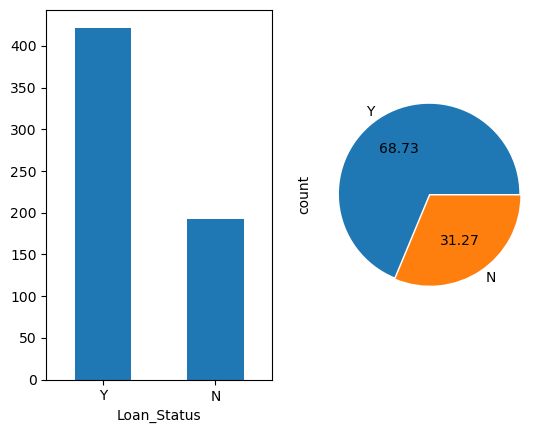

In [10]:
# Let's visualize our resuls
plt.subplot(1, 2, 1)
df["Loan_Status"].value_counts().plot(kind="bar")
plt.xticks(rotation=1)


plt.subplot(1, 2, 2)
df["Loan_Status"].value_counts().plot(kind="pie", explode=[0.01,0.01], autopct="%.2f")
plt.show()

In [17]:
# Check if null values are in dataset
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

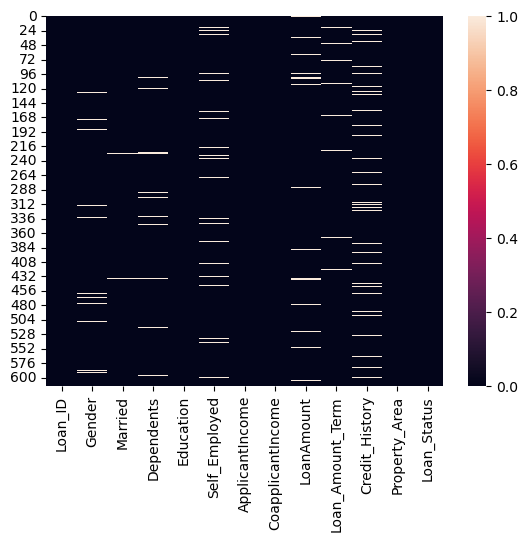

In [18]:
#Visualize null values
sns.heatmap(df.isnull())
plt.show()

In [19]:
#Display dataset
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [20]:
#Check if features are highly correlated to each other
df.select_dtypes(exclude=["category", "object"]).corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.116605,0.570909,-0.045306,-0.014715
CoapplicantIncome,-0.116605,1.000000,0.188619,-0.059878,-0.002056
LoanAmount,0.570909,0.188619,1.000000,0.039447,-0.008433
Loan_Amount_Term,-0.045306,-0.059878,0.039447,1.000000,0.001470
Credit_History,-0.014715,-0.002056,-0.008433,0.001470,1.000000


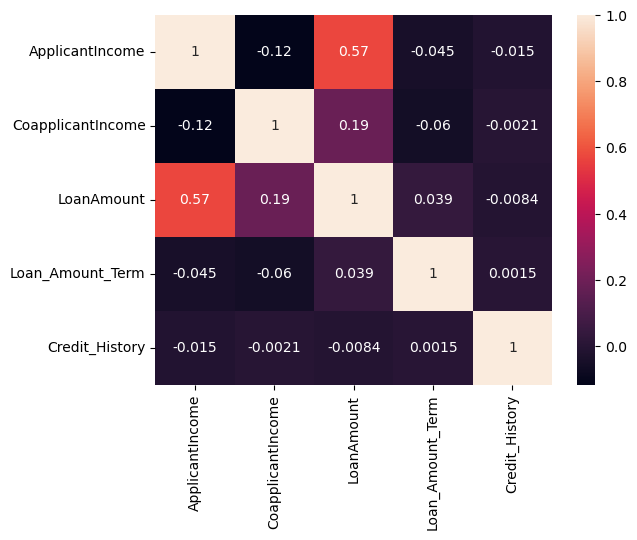

In [21]:
# Lets visualize correlation between our datasets
sns.heatmap(df.select_dtypes(exclude=["category", "object"]).corr(),
           annot=True);

In [22]:
#Display dataset
df.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [23]:
#Preprocess Dependent Feature
df_copy = df.copy()

#Display df_copy
df_copy.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [24]:
# Replace 3+ to 4
df_copy['Dependents'] = df_copy['Dependents'].replace('3+', 4)

# Change the type from categorical to numeric
df_copy["Dependents"] = pd.to_numeric(df_copy["Dependents"])

# Remove Loan ID from Dataset Copy
df_copy.drop("Loan_ID", axis=1, inplace=True)

In [25]:
#Get categorical feature
df_cat_feat = df_copy.select_dtypes(include=["category", "object"]).columns
df_num_feat = df_copy.select_dtypes(exclude=["category", "object"]).columns

In [26]:
print(f"Categorical features are: {df_cat_feat}\n")
print(f"Numerical features are: {df_num_feat}")

Categorical features are: Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area',
       'Loan_Status'],
      dtype='object')

Numerical features are: Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')


In [27]:
# Display data types
df_copy.dtypes

Gender                object
Married               object
Dependents           float64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [28]:
# Display infomations on the datasets
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    float64
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 57.7+ KB


In [29]:
# Display dataset
df_copy.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [30]:
# Check thetotal number of 
pd.crosstab(df_copy["Loan_Status"], df_copy["Gender"])

Gender,Female,Male
Loan_Status,,
N,37,150
Y,75,339


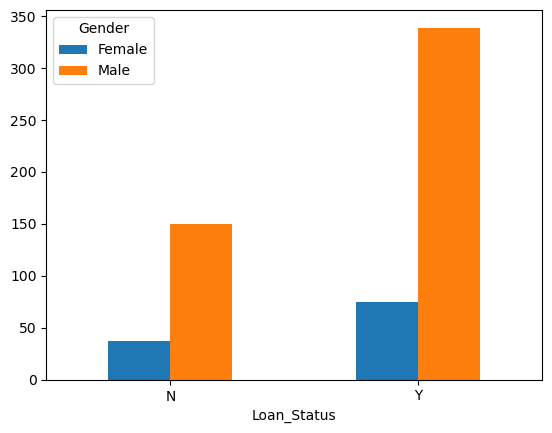

In [31]:
# Check thetotal number of 
pd.crosstab(df_copy["Loan_Status"], df_copy["Gender"]).plot(kind="bar")
plt.xticks(rotation=1)
plt.show()

In [32]:
# Display dataset
df_copy.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [33]:
pd.crosstab(columns=[df["Married"], df_copy["Education"]], index=df["Loan_Status"])

Married           No                   Yes             
Education   Graduate Not Graduate Graduate Not Graduate
Loan_Status                                            
N                 62           17       78           35
Y                106           28      231           54

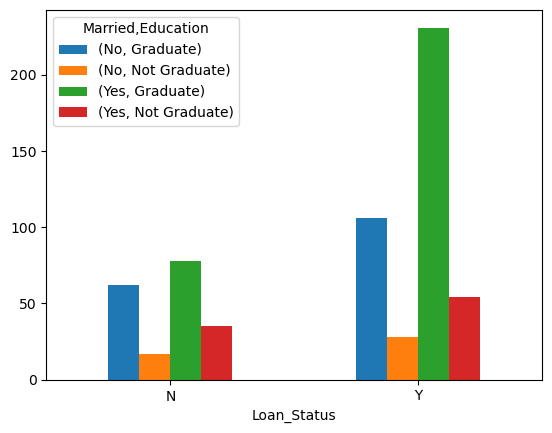

In [34]:
pd.crosstab(columns=[df["Married"], df_copy["Education"]], index=df["Loan_Status"]).plot(kind="bar")
plt.xticks(rotation=1)
plt.show()

In [35]:
#Display dataset
df_copy.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [36]:
# Check if there are outliers in out datasets
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Dependents,599.0,0.848080,1.220762,0.0,0.0,0.0,2.00,4.0
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


/tmp/ipykernel_16601/3461919135.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy[col])


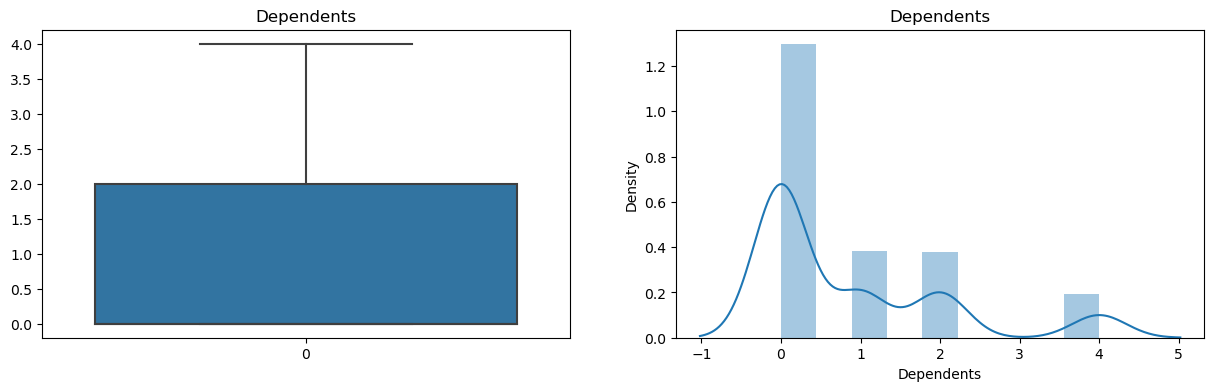

/tmp/ipykernel_16601/3461919135.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy[col])


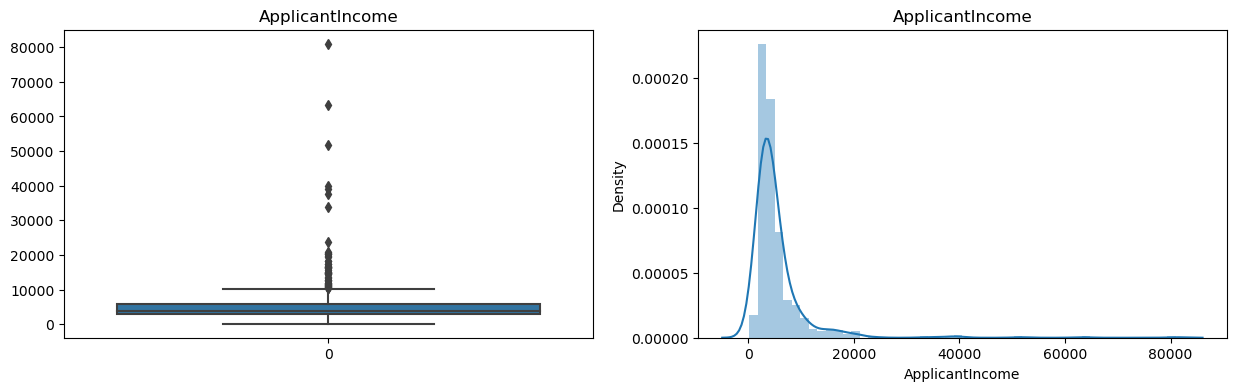

/tmp/ipykernel_16601/3461919135.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy[col])


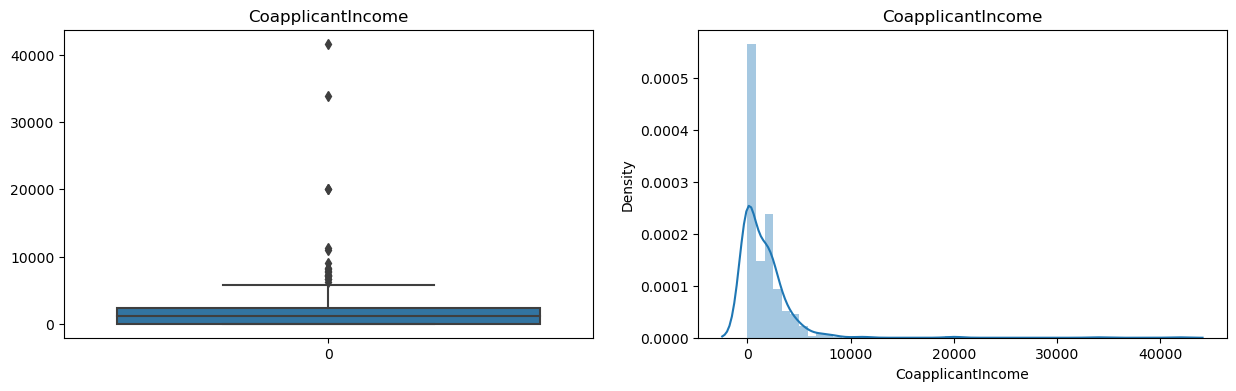

/tmp/ipykernel_16601/3461919135.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy[col])


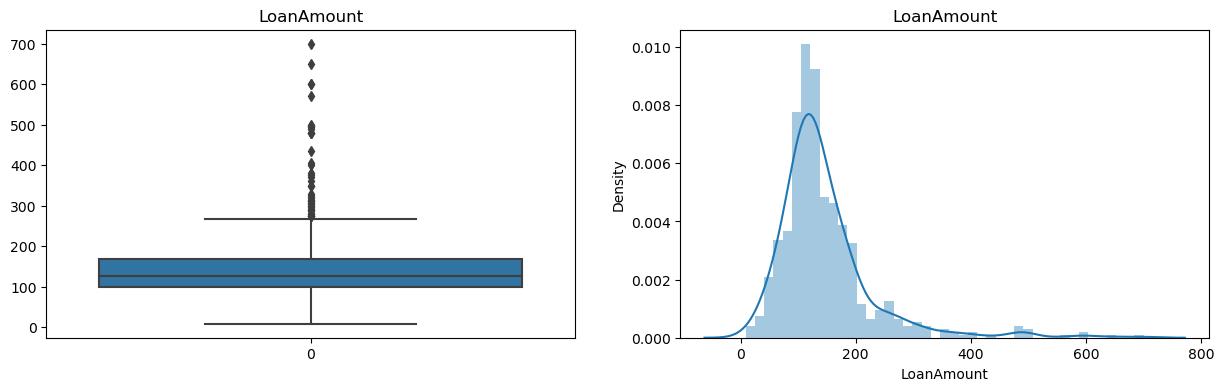

/tmp/ipykernel_16601/3461919135.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy[col])


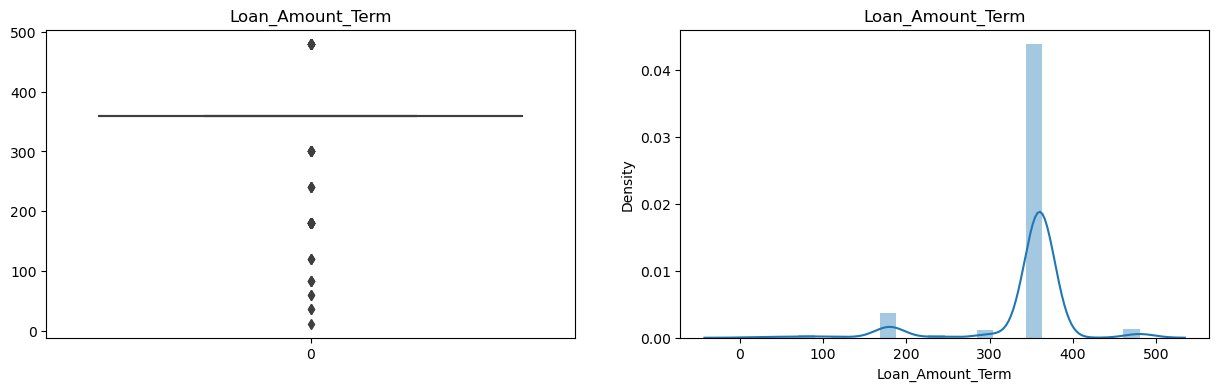

/tmp/ipykernel_16601/3461919135.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy[col])


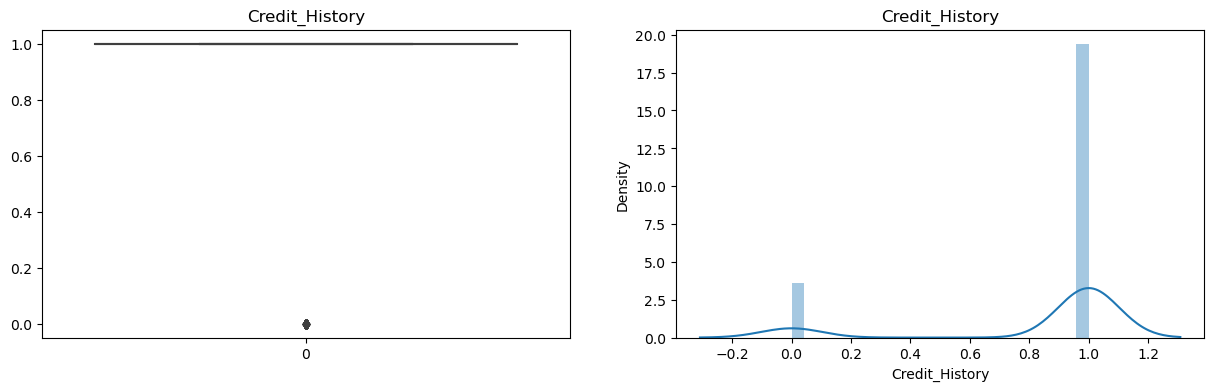

In [37]:
# Display Outliers ino our datasets
for col in df_num_feat:
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title(col)
    sns.boxplot(df_copy[col])
    plt.subplot(122)
    plt.title(col)
    sns.distplot(df_copy[col])
    plt.show()

## Observation
* Some Features had outliers in them
* Some Features had null values in them
* Some Features are categorical/object whiles others are numeric
* Non of our features were normally distributed

# Preprocess Dataset
Now that we have successfully explored our dataset, we are going to preprocess it in oder for it to be ready to be used to build our machine learning model. Here, we are going to deal with the following:

* Outliers
* Missing Values
* Categorical Features
* Scalling Of our Datasets

In [41]:
#Split our datasets into features and labels
x = df_copy.drop("Loan_Status", axis=1)
y = df_copy["Loan_Status"]

In [42]:
# Display x values
x.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [43]:
# Display y values
y

0      Y
1      N
2      Y
3      Y
4      Y
      ..
609    Y
610    Y
611    Y
612    Y
613    N
Name: Loan_Status, Length: 614, dtype: object

In [45]:
# Split our datasets into training and test set
x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=45,
                                                   stratify=y)

In [50]:
# Check the shape of each datasets
print(f"x_train {x_train.shape}")
print(f"y_train {y_train.shape}")
print(f"x_test {x_test.shape}")
print(f"y_test {y_test.shape}")

x_train (491, 11)
y_train (491,)
x_test (123, 11)
y_test (123,)


In [51]:
#Check the shape of original datasets
df_copy.shape

(614, 12)

In [70]:
# Setup pipeline for categorical features
cat_pip = Pipeline([
    ("step1-missing-values", SimpleImputer(strategy="constant", fill_value="missing")),
    ("step1-one-hot-encode", OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

num_pip = Pipeline([
    ("step1-missing-values", SimpleImputer(strategy="median")),
    ("step2-scale-dataset", MinMaxScaler())
])

In [73]:
# Define column trabsformer
col = ColumnTransformer([
    ("cat-pip", cat_pip, x_train.select_dtypes(include=["category", "object"]).columns),
    ("num-pip", num_pip, x_train.select_dtypes(exclude=["category", "object"]).columns)
])

In [74]:
col.fit(x_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('cat-pip',
                                 Pipeline(steps=[('step1-missing-values',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('step1-one-hot-encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], dtype='object')),
                                ('num-pip',
                                 Pipeline(steps=[('step1-missing-values',
                                                  SimpleImputer(strategy='median')),
                                                 ('step2-scale-dataset',
                                                  MinMaxScaler())]),
                                 Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object'))])

In [76]:
# Transform on both test and train datasets
new_x_train = col.transform(x_train)
new_x_test = col.transform(x_test)

In [77]:
# Display new_x_train_dataset
new_x_train

array([[0.        , 1.        , 0.        , ..., 0.14905933, 0.72972973,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.07380608, 0.72972973,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.15340087, 0.72972973,
        1.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.17510854, 0.72972973,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.24023155, 0.72972973,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.14327062, 0.72972973,
        1.        ]])

In [78]:
# Display new_x_test_dataset
new_x_test

array([[0.        , 1.        , 0.        , ..., 0.11722142, 0.72972973,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.38494935, 0.72972973,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.25759768, 0.32432432,
        1.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.31259045, 0.72972973,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.25904486, 0.32432432,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.16787265, 0.72972973,
        0.        ]])

In [80]:
# Display datasets
df_copy.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [81]:
# Initialize Label Encoder
leb = LabelEncoder()

In [83]:
# Preprocess our label features
new_y_train = leb.fit_transform(y_train)
new_y_test = leb.transform(y_test)

In [84]:
# Display y train datasets
new_y_train

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,

In [85]:
# Display y test dataset
new_y_test

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0])

In [91]:
col.transformers_

[('cat-pip',
  Pipeline(steps=[('step1-missing-values',
                   SimpleImputer(fill_value='missing', strategy='constant')),
                  ('step1-one-hot-encode',
                   OneHotEncoder(handle_unknown='ignore', sparse=False,
                                 sparse_output=False))]),
  Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], dtype='object')),
 ('num-pip',
  Pipeline(steps=[('step1-missing-values', SimpleImputer(strategy='median')),
                  ('step2-scale-dataset', MinMaxScaler())]),
  Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
         'Loan_Amount_Term', 'Credit_History'],
        dtype='object'))]

In [100]:
col.transformers_[0]

('cat-pip',
 Pipeline(steps=[('step1-missing-values',
                  SimpleImputer(fill_value='missing', strategy='constant')),
                 ('step1-one-hot-encode',
                  OneHotEncoder(handle_unknown='ignore', sparse=False,
                                sparse_output=False))]),
 Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], dtype='object'))

In [104]:
col.transformers_[0][1]

Pipeline(steps=[('step1-missing-values',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('step1-one-hot-encode',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))])

In [105]:
col.transformers_[0][1].named_steps

{'step1-missing-values': SimpleImputer(fill_value='missing', strategy='constant'),
 'step1-one-hot-encode': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)}

In [106]:
col.transformers_[0][1].named_steps['step1-one-hot-encode']

OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

In [113]:
one_hot_val = col.transformers_[0][1].named_steps['step1-one-hot-encode'].get_feature_names_out()
one_hot_val

array(['x0_Female', 'x0_Male', 'x0_missing', 'x1_No', 'x1_Yes',
       'x1_missing', 'x2_Graduate', 'x2_Not Graduate', 'x3_No', 'x3_Yes',
       'x3_missing', 'x4_Rural', 'x4_Semiurban', 'x4_Urban'], dtype=object)

In [109]:
#Display new x train datasets
pd.DataFrame(new_x_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.50,0.151186,0.000000,0.149059,0.72973,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.032776,0.000000,0.073806,0.72973,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.25,0.041148,0.054437,0.153401,0.72973,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.50,0.118964,0.000000,0.254703,0.72973,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.50,0.050105,0.103437,0.114327,0.72973,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.035340,0.098531,0.235890,0.72973,1.0
487,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.063779,0.068150,0.250362,0.72973,1.0
488,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.00,0.065836,0.000000,0.175109,0.72973,1.0
489,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.00,0.085745,0.063303,0.240232,0.72973,1.0


In [110]:
# Display df copy
df_copy.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [126]:
xtrain = pd.DataFrame(new_x_train, columns=['x0_Female', 'x0_Male', 'x0_missing', 'x1_No', 'x1_Yes',
                                   'x1_missing', 'x2_Graduate', 'x2_Not Graduate', 'x3_No', 'x3_Yes',
                                   'x3_missing', 'x4_Rural', 'x4_Semiurban', 'x4_Urban','Dependents', 
                                    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                                   'Loan_Amount_Term', 'Credit_History'])

xtest = pd.DataFrame(new_x_test, columns=['x0_Female', 'x0_Male', 'x0_missing', 'x1_No', 'x1_Yes',
                                   'x1_missing', 'x2_Graduate', 'x2_Not Graduate', 'x3_No', 'x3_Yes',
                                   'x3_missing', 'x4_Rural', 'x4_Semiurban', 'x4_Urban','Dependents', 
                                    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                                   'Loan_Amount_Term', 'Credit_History'])

In [127]:
# Display train dataset
xtrain.head()

,x0_Female,x0_Male,x0_missing,x1_No,x1_Yes,x1_missing,x2_Graduate,x2_Not Graduate,x3_No,x3_Yes,x3_missing,x4_Rural,x4_Semiurban,x4_Urban,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.50,0.151186,0.000000,0.149059,0.72973,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.032776,0.000000,0.073806,0.72973,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.25,0.041148,0.054437,0.153401,0.72973,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.50,0.118964,0.000000,0.254703,0.72973,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.50,0.050105,0.103437,0.114327,0.72973,1.0


In [128]:
# Display test dataset
xtest.head()

,x0_Female,x0_Male,x0_missing,x1_No,x1_Yes,x1_missing,x2_Graduate,x2_Not Graduate,x3_No,x3_Yes,x3_missing,x4_Rural,x4_Semiurban,x4_Urban,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.5,0.059348,0.000000,0.117221,0.729730,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.261383,0.000000,0.384949,0.729730,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.183693,0.000000,0.257598,0.324324,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.107617,0.000000,0.240232,0.324324,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.087961,0.166238,0.257598,0.729730,1.0
